In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [21]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

In [22]:
save_data = True

In [23]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [24]:
# expt_path=os.getcwd()+'\data_220623'
# expt_path=os.getcwd()+'\data_220712'
# expt_path=os.getcwd()+'\data_220801'
expt_path=os.getcwd()+'\data_220904'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data_220904


In [25]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


Load config

In [170]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Qubit/resonator to probe

In [27]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [165]:
qubit_i = 3
results_Qi = all_results[qubit_i]

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [29]:
im = InstrumentManager()

In [13]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [30]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

# RFSoC Calibration

In [16]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=1, # [us]
    readout_length=2, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=5000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)
tof.go(analyze=False, display=False, progress=True, save=False)

430 614
readout freq 950 +/- -805.34


  0%|          | 0/5000 [00:00<?, ?it/s]

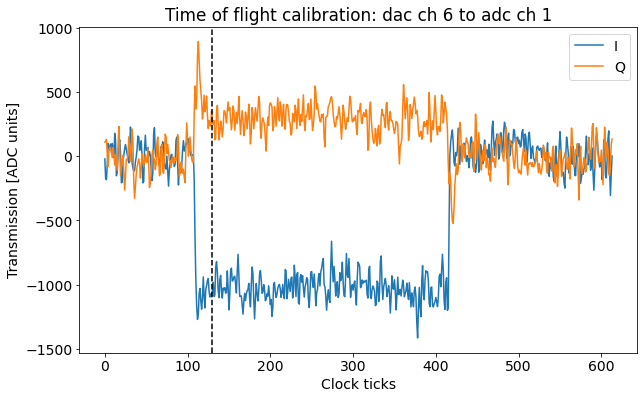

In [17]:
tof.display(adc_trig_offset=130)

# Initial single tone resonator spectroscopy

In [171]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 7 # MHz
npts = 250
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=1000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain = 0.015
rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
rspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/250 [00:00<?, ?it/s]

[79.62308892384405, 5000, 1000, -1.5707963267948966, 32.85555693198134, 10.272331703050737]
[ 8.11707209e+01  1.59852807e+08  6.39255826e+02  4.24478246e+00
  2.96628558e+01 -1.97249731e+01]

Freq with minimum transmission: 80.92508892384404
Freq with maximum transmission: 81.20508892384404
From fit:
	f0: 81.17072091378859
	Qi: 159852807.03757286
	Qe: 639.2558263052138
	Q0: 639.2532699135879
	kappa [MHz]: 0.126977404315446
	phi [radians]: 4.244782456203358


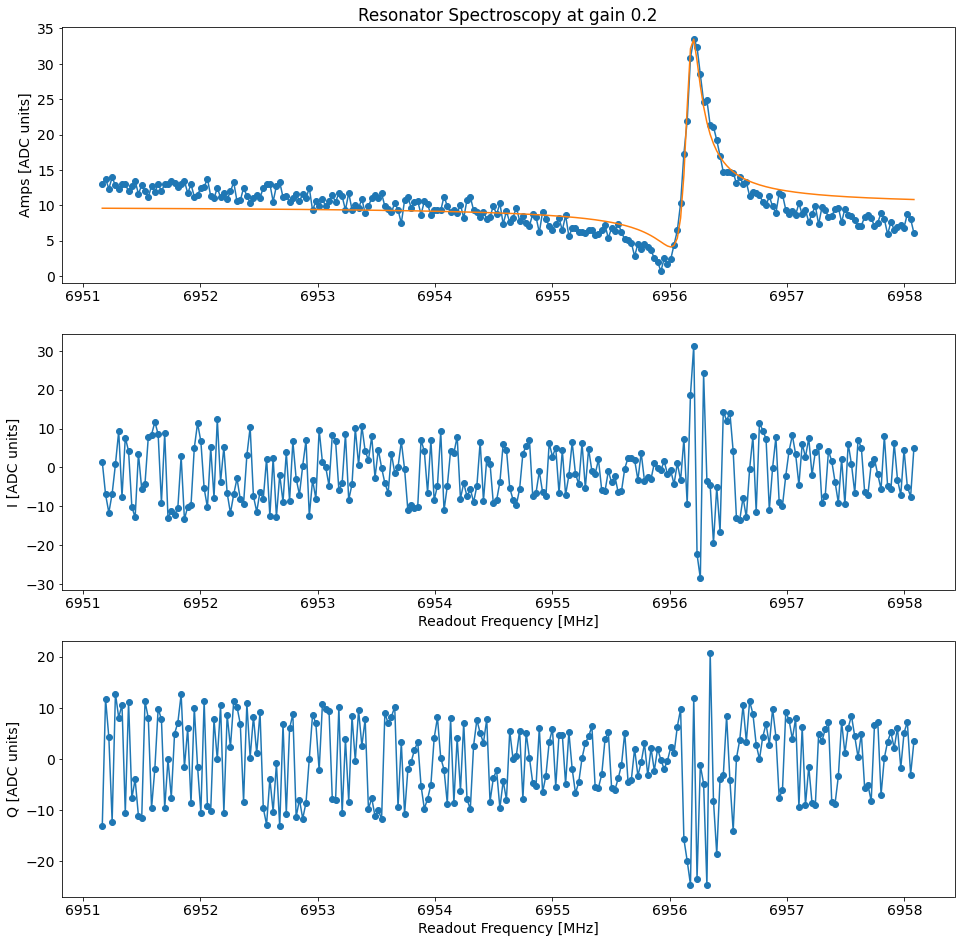

*Set cfg res 3 freq to 80.92508892384404*
*Set cfg res 3 gain to 0.2*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446}]


In [173]:
 # TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]
yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(all_results)

In [174]:
if save_data: saved_files.append(rspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_resonator_spectroscopy_qubit3.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [175]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 200
npts = 200

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/3), # Qubit pulse gain
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 446.8891052643975, HWHM -1.8851900340975172
Found peak in I at [MHz] 446.6603149904353, HWHM -1.3711035426184472
Found peak in Q at [MHz] 446.9151584417738, HWHM -2.627467696205997


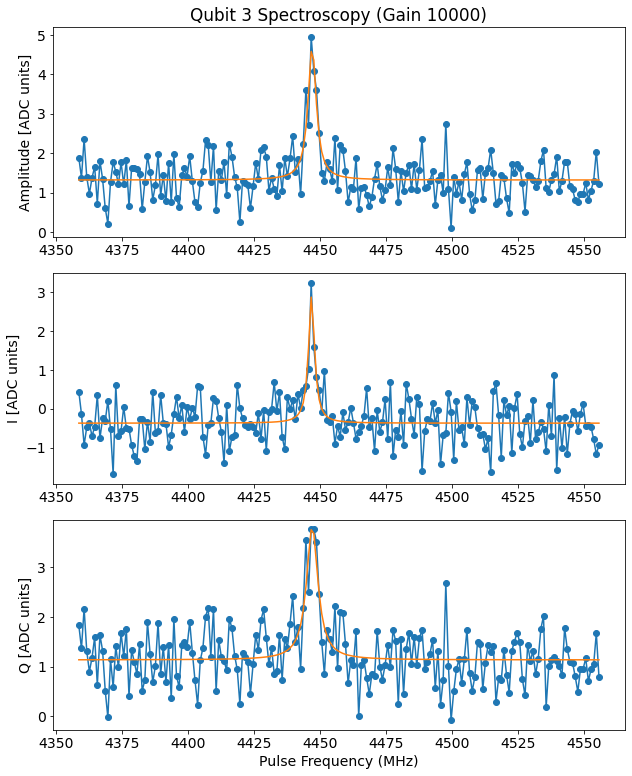

*Set qubit 3 f_ge to 446.8891052643975*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4446.889105264398}]


In [176]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data, compare_param_i=1)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [177]:
if save_data: saved_files.append(qspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_qubit_spectroscopy_qubit3.h5


## Pulse Probe (qubit) spectroscopy round 2

In [178]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 150

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/3), # Qubit pulse gain
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 444.8438816357183, HWHM 2.0798609064427924
Found peak in I at [MHz] 444.8744623574311, HWHM 2.688586701445739
Found peak in Q at [MHz] 444.96722258589244, HWHM 2.447290866272106


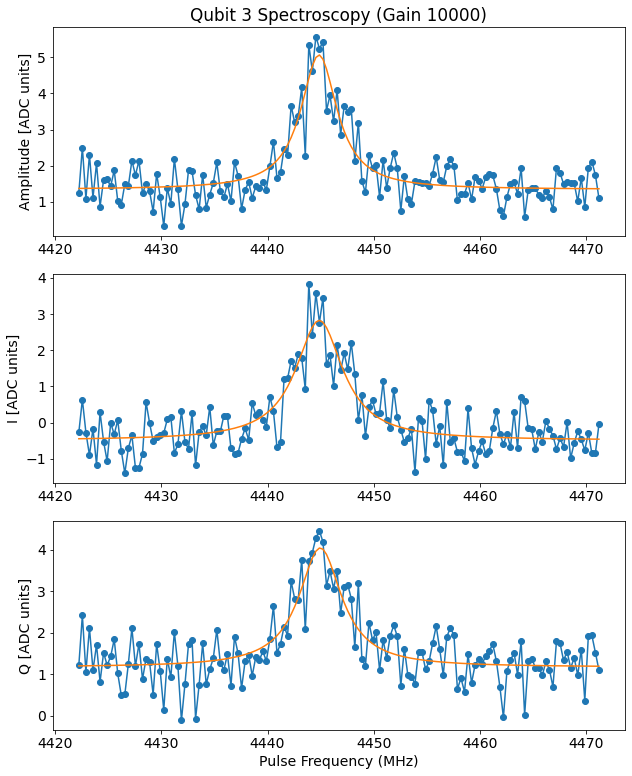

*Set qubit 3 f_ge to 444.8438816357183*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4444.843881635718}]


In [179]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data, compare_param_i=1)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [180]:
if save_data: saved_files.append(qspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_qubit_spectroscopy_qubit3.h5


## Length Rabi

In [185]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=151,
    reps=4000,
    gain=25000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubit=qubit_i,
)
lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]
lengthrabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 95.66571, which is out of bounds 0.23489697986577185 to 35.234546979865776. Instead init to 17.734721979865775
Attempted to init fitparam 1 to 93.3324, which is out of bounds 0.23489697986577185 to 35.234546979865776. Instead init to 17.734721979865775
Attempted to init fitparam 1 to 109.66557, which is out of bounds 0.23489697986577185 to 35.234546979865776. Instead init to 17.734721979865775
Decay from avgi [us] 0.10000000000000002
Pi length from avgi data [us]: 0.03143029972370555
	Pi/2 length from avgi data [us]: 0.015715149861852774

Decay from avgq [us] 0.8774341608330718
Pi length from avgq data [us]: 0.1509113089482507
Pi/2 length from avgq data [us]: 0.07545565447412535


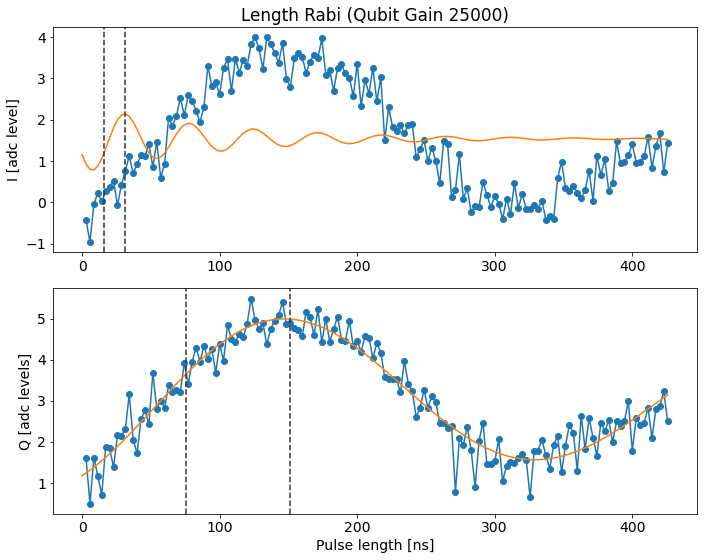

Will use sigma 0.13523255301119036 for amplitude rabi


In [186]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data, compare_param_i=1)

lengthrabi.display(fit=True)
p = lengthrabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
else: pi_len = (3/2 - p[2]/180)/2/p[1]
pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

lengthrabi_decay = p[3]

print(f'Will use sigma {pi_len} for amplitude rabi')

In [187]:
if save_data: saved_files.append(lengthrabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_length_rabi_qubit3.h5


## Amplitude Rabi

In [188]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=30,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.0008530805687203792, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
Attempted to init fitparam 1 to 0.0016429699842022117, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
Attempted to init fitparam 1 to 0.0016429699842022117, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
2


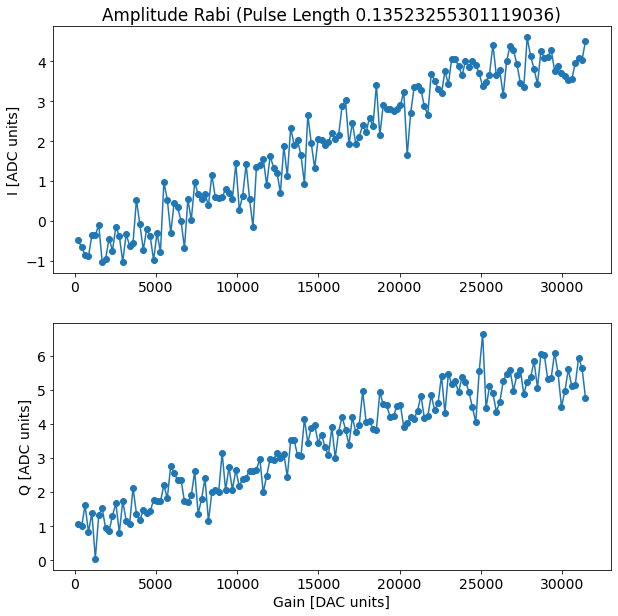

*Set pi pulse sigma for qubit 3 to 0.13523255301119036*
*Set pi pulse gain for qubit 3 to 30000*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4444.843881635718, 'Pi pulse len': 0.13523255301119036, 'Pi pulse gain': 30000}]


In [189]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data, compare_param_i=2, override='avgq')

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(all_results)

In [191]:
if save_data: saved_files.append(amprabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_amp_rabi_qubit3.h5


## $T_1$

In [192]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = False

In [197]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 300
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    # reps=5,
    rounds=30,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Fit T1 avgi [us]: 109.82948806545751
Fit T1 avgq [us]: 106.7447800590098


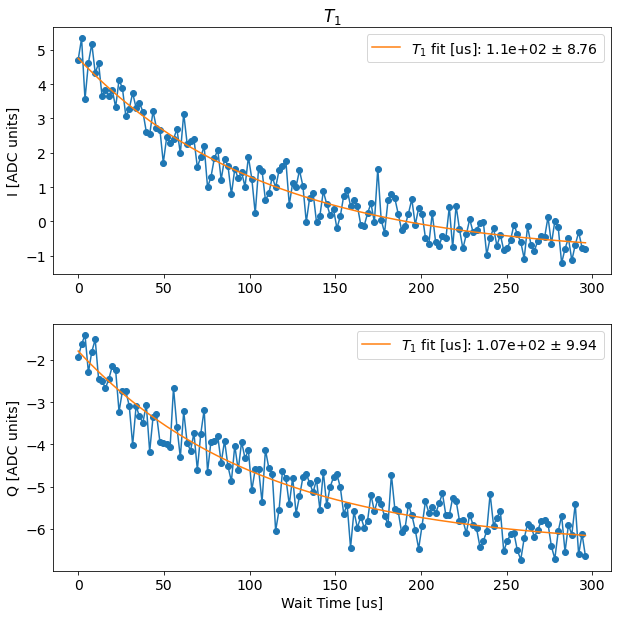

*Set qubit 3 T1 to 110.0*
*Set readout 3 relax delay to 329.0*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4444.843881635718, 'Pi pulse len': 0.13523255301119036, 'Pi pulse gain': 30000, 'T1': 109.82948806545751, 'T1 err': 8.762700987859944}]


In [198]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit=True)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data, compare_param_i=3)

t1.display(fit=True)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(3*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(all_results)

In [199]:
if save_data: saved_files.append(t1.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_t1_qubit3.h5


## $T_2$ Ramsey round 1

In [200]:
ramsey_freq = max(min(np.abs(np.ceil(qubit_hwhm)), 4), 2)
print(f'Ramsey freq [MHz]: {ramsey_freq}')

t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=151,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=100,
    # reps=5,
    rounds=30,
    qubit=qubit_i,
)
t2r.go(analyze=False, display=False, progress=True, save=False)

Ramsey freq [MHz]: 3.0


  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 4.433288999999999, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Current qubit frequency: 444.8438816357183
Fit frequency from I [MHz]: 2.1378156097803127 +/- 0.001786460654909146
Suggested new qubit frequency from fit I [MHz]:
 	445.70606602593796
 	439.70606602593796
T2 Ramsey from fit I [us]: 30.340953470770163
Fit frequency from Q [MHz]: 2.1388299450954267 +/- 0.0023090080076169223
Suggested new qubit frequencies from fit Q [MHz]:
 	445.70505169062284
 	439.70505169062284
T2 Ramsey from fit Q [us]: 29.388196234389312


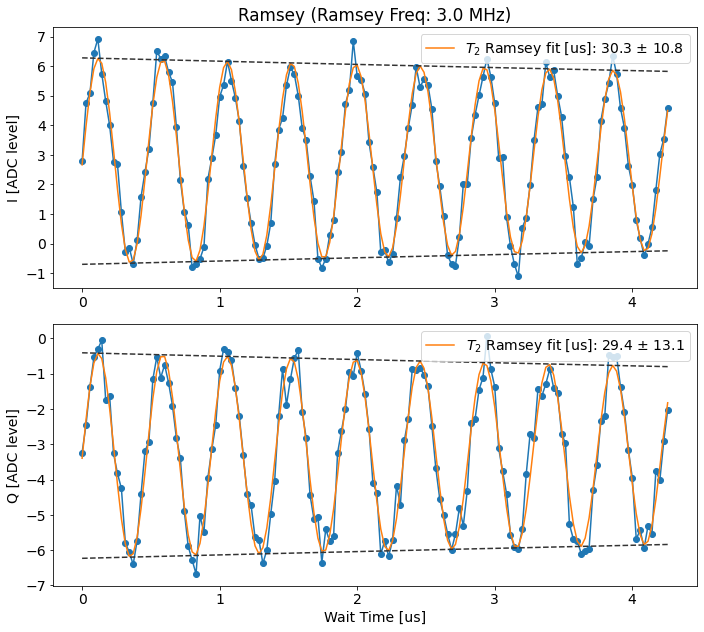

*Set qubit 3 freq to 445.70505169062284*
Alt qubit freq is 439.70505169062284


In [201]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

t2r.analyze(fit=True)

t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

In [202]:
if save_data: saved_files.append(t2r.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_ramsey_qubit3.h5


## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [203]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(15), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/3, # [MHz]
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Current qubit frequency: 445.70505169062284
Fit frequency from I [MHz]: 1.007304163721797 +/- 0.001411154928953036
Suggested new qubit frequency from fit I [MHz]:
 	445.697747526901
 	443.697747526901
T2 Ramsey from fit I [us]: 30.121038516926394
Fit frequency from Q [MHz]: 1.0054997827383767 +/- 0.0014734420160524046
Suggested new qubit frequencies from fit Q [MHz]:
 	445.6995519078845
 	443.6995519078845
T2 Ramsey from fit Q [us]: 45.73124517759833


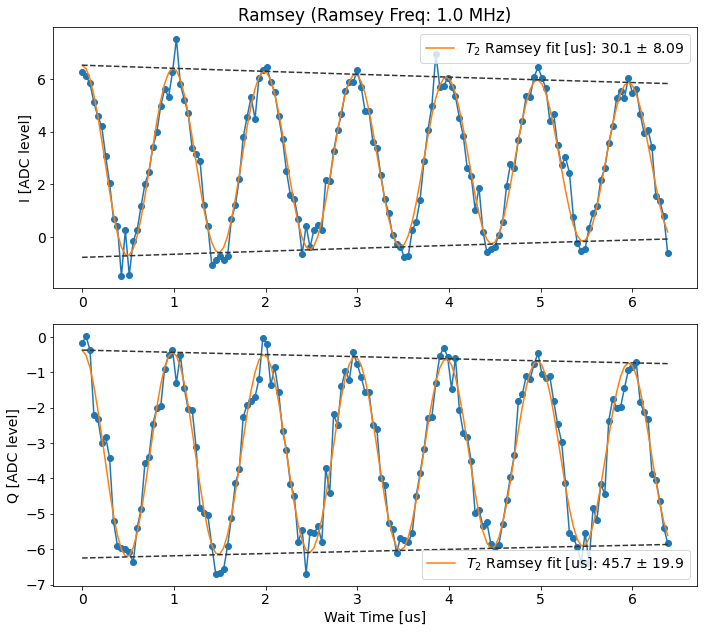

*Set qubit 3 freq to 445.6995519078845*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4445.699551907885, 'Pi pulse len': 0.13523255301119036, 'Pi pulse gain': 30000, 'T1': 109.82948806545751, 'T1 err': 8.762700987859944, 'T2R': 45.73124517759833, 'T2R err': 19.854848839224584}]
Redo T2R: False


In [204]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(all_results)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [205]:
if save_data: saved_files.append(t2r_2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_ramsey_qubit3.h5


## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [206]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=100,
        # reps=10,
        rounds=30,
        qubit=qubit_i,
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

In [207]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    t2r_3_fit, t2r_3_fit_err, t2r_3_adjust = meas.fitting.get_best_fit(t2r_3.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

In [208]:
if redo_t2r:
    if save_data: saved_files.append(t2r_3.save_data())

## $T_2$ Echo

In [209]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(10), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=max(ramsey_freq/4, 0.300), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Current qubit frequency: 445.6995519078845
Fit frequency from I [MHz]: 0.7494997225303659 +/- 0.0018146816335514503
Suggested new qubit frequency from fit I [MHz]:
 	445.70005218535414
 	444.20005218535414
T2 Echo from fit I [us]: 33.6579458616294
Fit frequency from Q [MHz]: 0.7502584688373857 +/- 0.002048663854488743
Suggested new qubit frequencies from fit Q [MHz]:
 	445.6992934390471
 	444.1992934390471
T2 Echo from fit Q [us]: 37.9827488282999


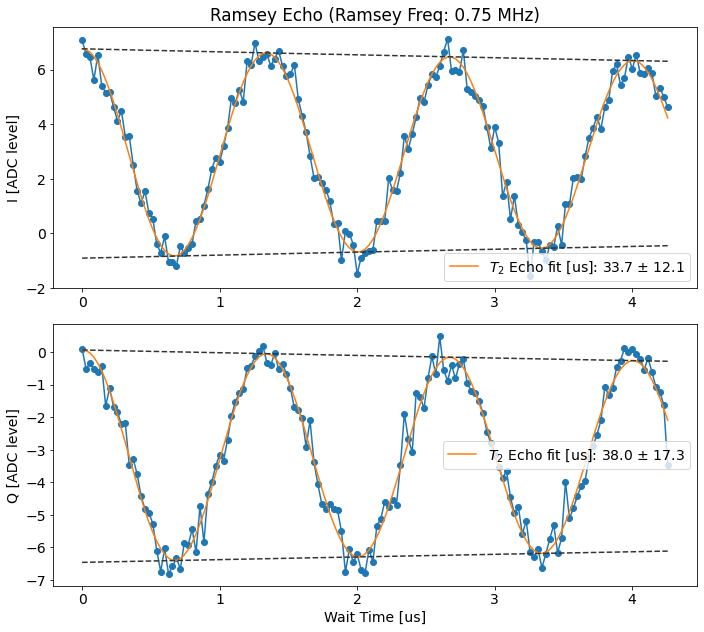

[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4445.699551907885, 'Pi pulse len': 0.13523255301119036, 'Pi pulse gain': 30000, 'T1': 109.82948806545751, 'T1 err': 8.762700987859944, 'T2R': 45.73124517759833, 'T2R err': 19.854848839224584, 'T2E': 10.127283888653848, 'T2E err': 4.011702110173353}]


In [210]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

t2e.analyze(fit=True)

t2e_fit, t2e_fit_err, t2e_adjust = meas.fitting.get_best_fit(t2e.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(all_results)
# print('Results updated.')

In [211]:
if save_data: saved_files.append(t2e.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_echo_qubit3.h5


# Resonator chi shift (g/e)

In [ ]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 201
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span, # MHz
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/201 [00:00<?, ?it/s]

[-82.77643781094528, 5000, 1000, -1.5707963267948966, 24.36139480428421, 30.50685639787162]
[-8.27302608e+01 -3.89049477e+07  4.88169254e+01 -2.47341144e+00
  2.98241805e+00  2.70790001e+01]

Freq with minimum transmission: -80.36350248756219
Freq with maximum transmission: -81.65703482587064
From fit:
	f0: -82.73026079000164
	Qi: -38904947.67787944
	Qe: 48.816925438287235
	Q0: 48.81698669258371
	kappa [MHz]: -1.6947023238238923
	phi [radians]: -2.4734114416872854


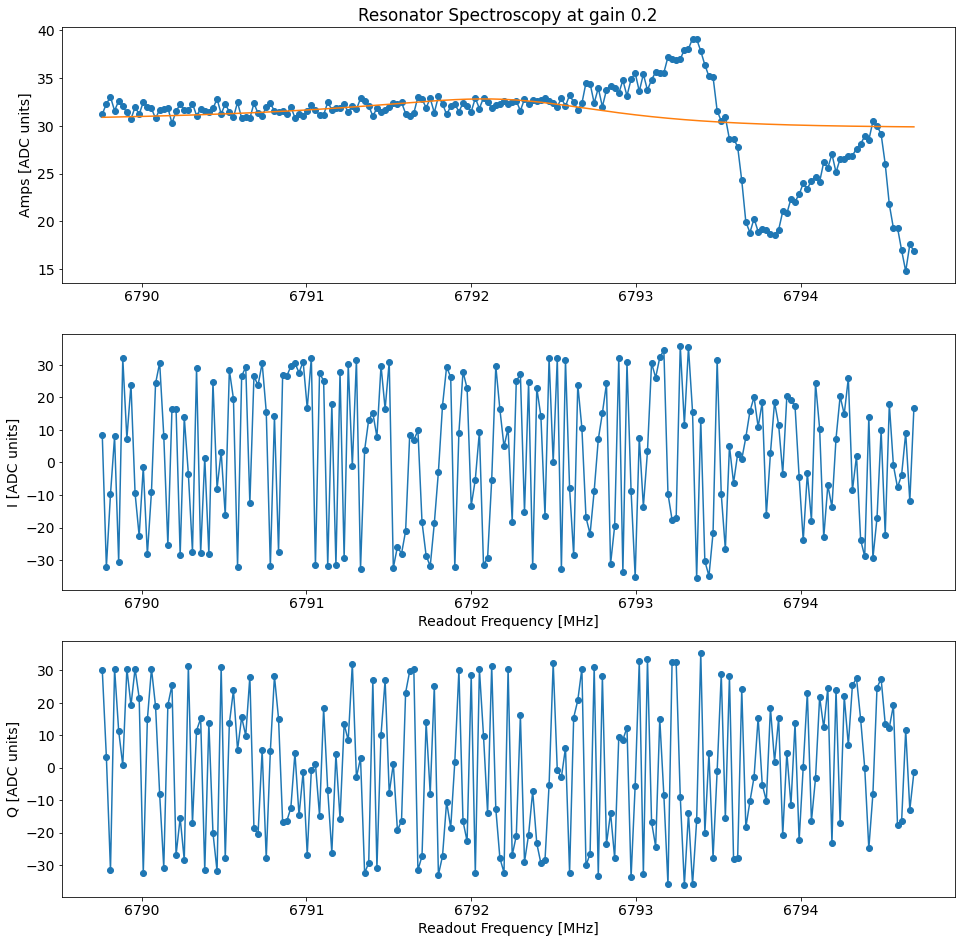

[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 4160.544663455941, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641}, {}]


In [ ]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
res_freq_e = rspec_chi_fit[0]
# res_freq_e = -83
results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [ ]:
if save_data: saved_files.append(rspec_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220801\00000_resonator_spectroscopy_chi_qubit2.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [212]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 180
npts = 180

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=2, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    # gain=5000,
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 273.07609041004275, HWHM 2.044045164866973
Found peak in I at [MHz] 273.72761621958944, HWHM 1.8427189438691203
Found peak in Q at [MHz] 273.07506076528307, HWHM -1.976976147710528


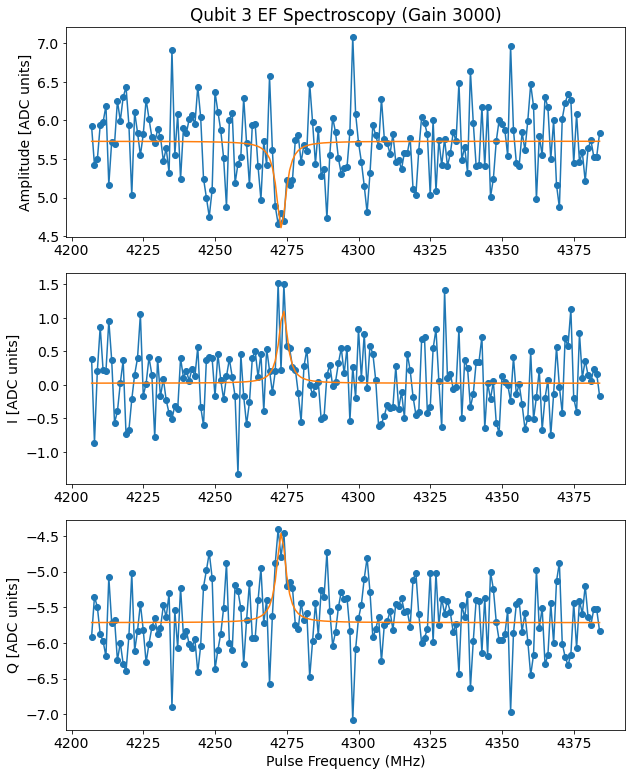

*Set qubit 3 f_ef to 273.07506076528307*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4445.699551907885, 'Pi pulse len': 0.13523255301119036, 'Pi pulse gain': 30000, 'T1': 109.82948806545751, 'T1 err': 8.762700987859944, 'T2R': 45.73124517759833, 'T2R err': 19.854848839224584, 'T2E': 10.127283888653848, 'T2E err': 4.011702110173353, 'Qubit EF freq': 4273.075060765283}]


In [213]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [214]:
if save_data: saved_files.append(qEFspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_qubit_EF_spectroscopy_qubit3.h5


## Pulse Probe EF spectroscopy round 2

In [215]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=2, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 267.1835789714291, HWHM 0.5036214342638476
Found peak in I at [MHz] 273.0442934803935, HWHM 1.2815799123463174
Found peak in Q at [MHz] 273.2079183734708, HWHM 1.4618252411853745


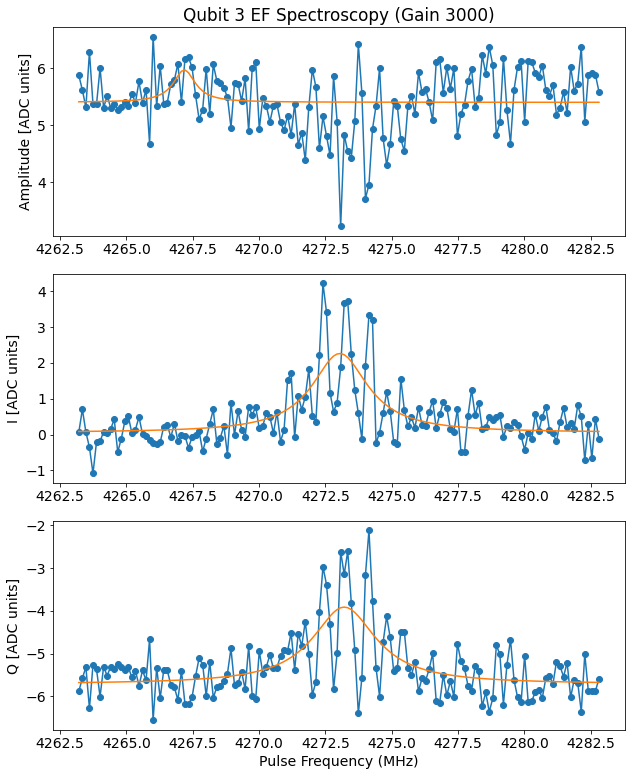

*Set qubit 3 f_ef to 273.2079183734708*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4445.699551907885, 'Pi pulse len': 0.13523255301119036, 'Pi pulse gain': 30000, 'T1': 109.82948806545751, 'T1 err': 8.762700987859944, 'T2R': 45.73124517759833, 'T2R err': 19.854848839224584, 'T2E': 10.127283888653848, 'T2E err': 4.011702110173353, 'Qubit EF freq': 4273.20791837347}]


In [216]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data, compare_param_i=2)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [217]:
if save_data: qEFspec2.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_qubit_EF_spectroscopy_qubit3.h5


## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [218]:
amprabiEF = meas.AmplitudeRabiEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=30,
    # sigma_test=0.095, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 100, 29, 110.0], 'f_ge': [828.193, 3470.7039558072906, 160.544663455941, 445.6995519078845], 'f_ef': [637.4704365863639, 3370.260942584849, -81.47654241457579, 273.2079183734708], 'f_EgGf': [2007.267, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 30000, 30000, 30000], 'sigma': [0.135, 0.0882, 0.198, 0.13523255301119036], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [25271, 22889, 30000, 30000], 'sigma': [0.09, 0.095, 0.095, 0.09], 'type': 'gauss'}, 'pi_EgGf': {'gain': [2500, 0, 3000, 3000], 'sigma': [0.335, 0, 0.4, 0.4], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.37, -806.77, -80.4, 80.92508892384404], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.3, 0.27, 0.27, 0.2], 'readout_length': [10, 10, 10, 10], 'relax_delay': [150, 300, 140, 329.0]}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyqu

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.000569620253164557, which is out of bounds 3.196522183863956e-06 to 0.0004794783275795934. Instead init to 0.0002413374248817287
Attempted to init fitparam 1 to 0.0007911392405063292, which is out of bounds 3.196522183863956e-06 to 0.0004794783275795934. Instead init to 0.0002413374248817287
Pi gain from avgi data [dac units]: 26013
	Pi/2 gain from avgi data [dac units]: 13006
Pi gain from avgq data [dac units]: 19229
	Pi/2 gain from avgq data [dac units]: 9614


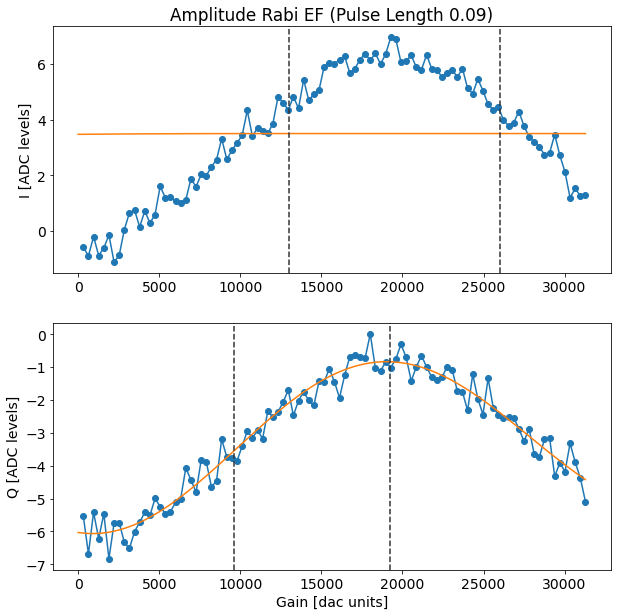

*Set EF pi pulse sigma for qubit 3 to 0.09*
*Set EF pi pulse gain for qubit 3 to 9346*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4445.699551907885, 'Pi pulse len': 0.13523255301119036, 'Pi pulse gain': 30000, 'T1': 109.82948806545751, 'T1 err': 8.762700987859944, 'T2R': 45.73124517759833, 'T2R err': 19.854848839224584, 'T2E': 10.127283888653848, 'T2E err': 4.011702110173353, 'Qubit EF freq': 4273.20791837347, 'EF pi pulse len': 0.09, 'EF pi pulse 

In [219]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data, compare_param_i=1)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [220]:
if save_data: amprabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_amp_rabi_EF_qubit3.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [221]:
ramseyEF_freq = max(min(np.abs(np.ceil(qubitEF_hwhm)), 4), 2)

t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=100,
    rounds=30,
    qubit=qubit_i,
)
t2EFr.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 15.399845999999998, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Current EF frequency: 273.2079183734708
Fit frequency from I [MHz]: 3.0687211669924928
Suggested new EF frequencies from fit avgi [MHz]:
 	273.13919720647834
 	267.13919720647834
T2 Ramsey EF from fit avgi [us]: 6.516503703051961
Fit frequency from Q [MHz]: 3.060317174941759
Suggested new EF frequencies from fit avgq [MHz]:
 	273.14760119852906
 	267.14760119852906
T2 Ramsey EF from fit avgq [us]: 7.712777663294623


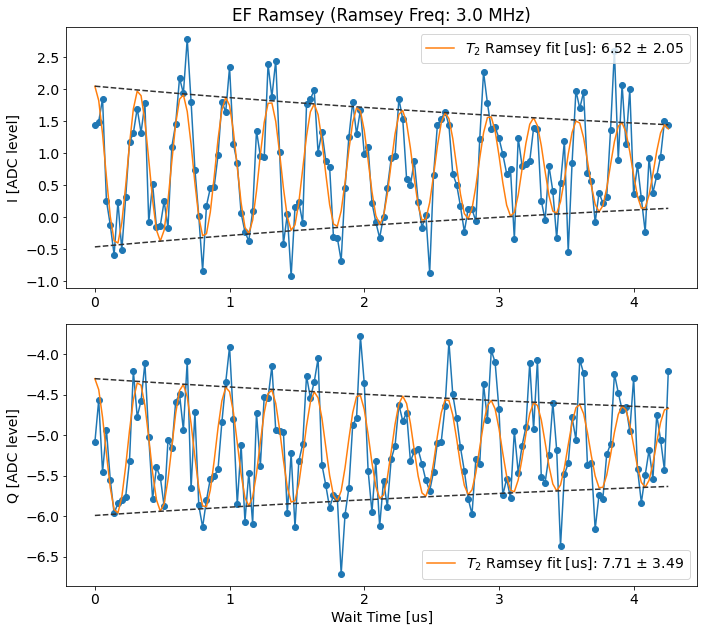

*Set qubit 3 EF freq to 274.4176421308761*
[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {'Res freq': 6955.925088923844, 'Res kappa': 0.126977404315446, 'Qubit freq': 4445.699551907885, 'Pi pulse len': 0.13523255301119036, 'Pi pulse gain': 30000, 'T1': 109.82948806545751, 'T1 err': 8.762700987859944, 'T2R': 45.73124517759833, 'T2R err': 19.854848839224584, 'T2E': 10.127283888653848, 'T2E err': 4.011702110173353, 'Qubit EF freq': 4274.417642130876, 'EF pi pulse len': 0.09, 'EF pi pulse gain': 9346}]


In [222]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, compare_param_i=3, get_best_data_params=['f_ef_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [223]:
if save_data: t2EFr.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_ramseyEF_qubit3.h5


# Resonator chi shift (e/f)

In [125]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 250
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/250 [00:00<?, ?it/s]

[-85.24026079000164, 5000, 1000, -1.5707963267948966, 4.340444736495847, 30.590071700636685]
[-8.27702608e+01 -4.95369566e+06  3.24330517e+01  1.55230450e+00
  2.07372502e+00  2.90125360e+01]

Freq with minimum transmission: -85.39026079000163
Freq with maximum transmission: -82.77026079000164
From fit:
	f0: -82.77026079000166
	Qi: -4953695.661248373
	Qe: 32.433051662963734
	Q0: 32.43326401144035
	kappa [MHz]: -2.552017606393414
	phi [radians]: 1.5523045022291968


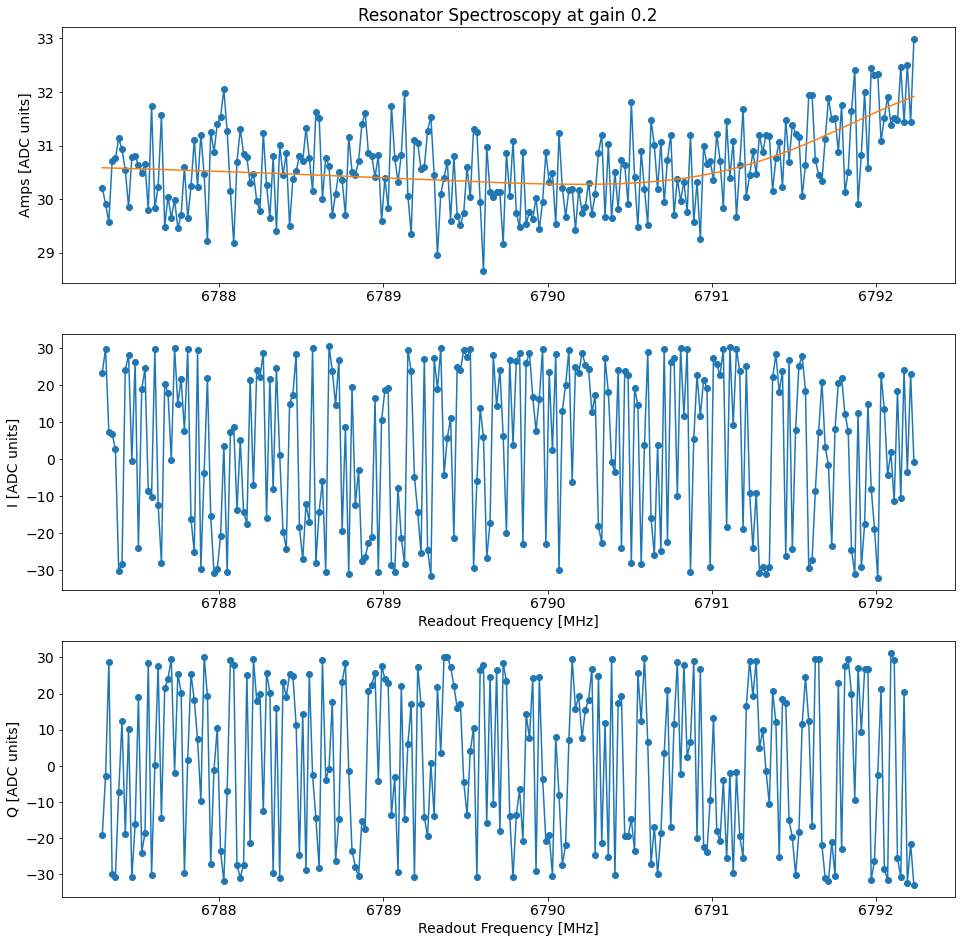

[{'Res freq': 7688.069984606071, 'Res kappa': 0.19160023319307243}, {}, {'Res freq': 6794.736, 'Res kappa': 0.2396313991532582, 'Qubit freq': 3919.3464108724183, 'Pi pulse gain': 30000, 'T1': 28.955625009978505, 'T1 err': 0.7124544460457642, 'T2R': 1.9767111846074334, 'T2R err': 0.07757187447843363, 'T2E': 33.43198801661562, 'T2E err': 5.596076538529404, 'Res chi shift (e - g)': -2.466260790001641, 'Qubit EF freq': 3919.2526591907176, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.5062607900016616}, {}]


In [126]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
res_freq_f = rspecEF_chi_fit[0]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [127]:
if save_data: rspecEF_chi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_resonator_spectroscopy_chi_qubit2.h5


# Single Shot

## Single shot optimization

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
npts_f = 8

span_gain = 140
# npts_gain = 2
npts_gain = 7

span_len = 15 # us
# npts_len = 2
npts_len = 5

shotopt.cfg.expt = dict(
    reps=100000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=150,
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain,

    start_len=10,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 35], 'T2R': [13, 20], 'f_ge': [3646.7584779001595, 4536.33065792081], 'f_ef': [3487.35, 4354.3124984175265], 'f_EgGf': 5243.181945338396, 'pulses': {'pi_ge': {'gain': [29284, 2154], 'sigma': [0.3, 0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [24292, 3586], 'sigma': [0.5, 0.02], 'type': 'gauss'}, 'pi_EgGf': {'gain': 15170, 'sigma': 0.4, 'type': 'gauss'}}}, 'readout': {'trig_offset': 180, 'frequency': [552.2, 1751.5253727591987], 'gain': [94, 255], 'phase': [-0.21743215294427692, -3.095165520548619], 'threshold': [72.01127819598226, -2.544007934071093], 'readout_length': [13, 22], 'relax_delay': [200, 150]}}, 'hw': {'lo': {'readout': {'frequency': '5.4e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [3, 1], 'nyquist': [2, 2]}, 'swap': {'ch': 1, 'nyquist': 2}, 'readout': {'ch': [0, 4], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC26C3', 'soc': 'Qick186'}, 'expt': {'reps': 100000, 'qubit': 1, 'start_f': 1750.025

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
shotopt.analyze()
print(shotopt.data['fid'])

(6, 6, 2)
[1750.02537276 1750.27537276 1750.52537276 1750.77537276 1751.02537276
 1751.27537276 1751.52537276 1751.77537276]
[150 170 190 210 230 250 270]
[10. 13. 16. 19. 22.]
Max fidelity 0.23594589864746618
Set params: 
 angle (deg) -4.944448307509958 
 threshold 3.277441669013662 
 freq [Mhz] 1751.5253727591987 
 gain [dac units] 270 
 readout length [us] 16.0
[[[0.01682008 0.01341007 0.01126006 0.01101006 0.01490007]
  [0.01511008 0.01690008 0.01728017 0.01579008 0.01560016]
  [0.01468015 0.01793009 0.01799009 0.01894009 0.0198303 ]
  [0.0196801  0.02366012 0.01772009 0.02299011 0.01835009]
  [0.01798009 0.0193801  0.02228011 0.02124011 0.0196401 ]
  [0.0201102  0.02239011 0.02387024 0.02159011 0.02301012]
  [0.02533013 0.02573039 0.02566026 0.02456025 0.02144011]]

 [[0.02697013 0.02618013 0.02557013 0.02589039 0.02283011]
  [0.02641013 0.02903015 0.02653013 0.02713014 0.02934015]
  [0.03406034 0.03354017 0.02885014 0.03038015 0.02783014]
  [0.03447052 0.0401702  0.03671018 0.038

In [ ]:
if save_data: shotopt.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_single_shot_opt_qubit1.h5


## Best readout parameters

In [162]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=50000,
    check_f=True,
    qubit=qubit_i,
)

shot.cfg.device.readout.frequency=-80.4
shot.cfg.device.readout.gain=0.270
# shot.cfg.device.readout.readout_length = 16 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 100, 29.0, 53], 'f_ge': [828.193, 3470.7039558072906, 160.54466345594093, 457.5215351802661], 'f_ef': [637.4704365863639, 3370.260942584849, -80.74734080928225, 295.9599], 'f_EgGf': [2007.267, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 30000, 30000, 12734], 'sigma': [0.135, 0.0882, 0.19889940961434324, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [25271, 22889, 30000, 3821], 'sigma': [0.09, 0.095, 0.095, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [2500, 0, 7800, 10000], 'sigma': [0.335, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': -80.4, 'lo_sideband': [1, -1, 1, 1], 'gain': 0.27, 'readout_length': [10, 10, 10, 10], 'relax_delay': [150, 300, 87.0, 150]}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Unrotated:
Ig -1.1360234298730882 +/- 20.847123157738068 	 Qg -17.8374552554507 +/- 21.657073153019123 	 Amp g 17.873593908988376
Ie 14.890660592255125 +/- 22.408034174138972 	 Qe 12.727790432801822 +/- 26.649516661674397 	 Amp e 19.588987267724214
If 16.162382037097302 +/- 22.633128053264628 	 Qf 14.503091441588026 +/- 26.93734553912365 	 Amp f 21.715484210032006
Rotated:
Ig -16.437344714242602 +/- 20.847123157738068 	 Qg -7.353501280358638 +/- 21.657073153019123 	 Amp g 18.007228613395103
Ie 19.103979037335733 +/- 22.408034174138972 	 Qe -7.541436662189985 +/- 26.649516661674397 	 Amp e 20.538629019211246
If 21.39157405446259 +/- 22.633128053264628 	 Qf -8.077689012391218 +/- 26.93734553912365 	 Amp f 22.865880702664022


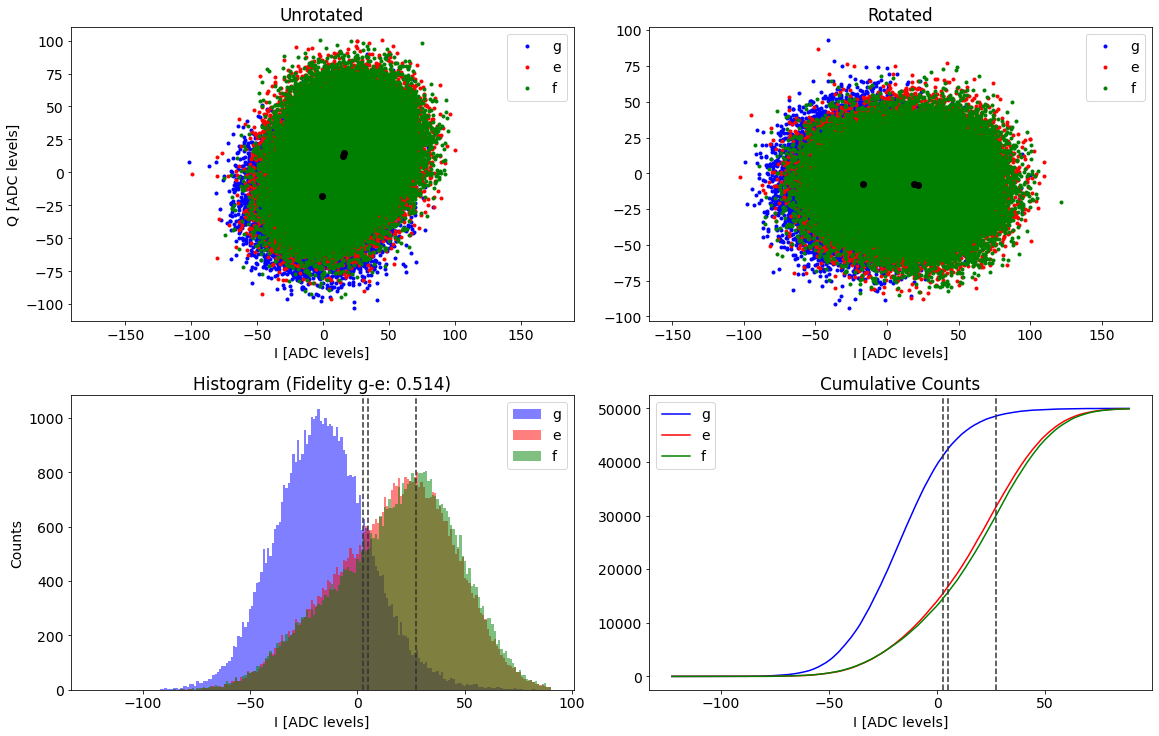

ge fidelity (%): 51.44492475184118
gf fidelity (%): 53.5517703808971
ef fidelity (%): 3.264308887731806
rotation angle (deg): -61.85843525468416
set angle to (deg): 61.85843525468416
threshold ge: 2.715537008841963
threshold gf: 4.843634978073595
threshold ef: 27.1886636550056


In [163]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

In [164]:
if save_data: shot.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_single_shot_qubit2.h5


# Results

In [224]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

{'device': {'qubit': {'T1': [50, 100, 29, 110.0], 'f_ge': [828.193, 3470.7039558072906, 160.544663455941, 445.6995519078845], 'f_ef': [637.4704365863639, 3370.260942584849, -81.47654241457579, 274.4176421308761], 'f_EgGf': [2007.267, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 30000, 30000, 30000], 'sigma': [0.135, 0.0882, 0.198, 0.13523255301119036], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [25271, 22889, 30000, 9346], 'sigma': [0.09, 0.095, 0.095, 0.09], 'type': 'gauss'}, 'pi_EgGf': {'gain': [2500, 0, 3000, 3000], 'sigma': [0.335, 0, 0.4, 0.4], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.37, -806.77, -80.4, 80.92508892384404], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.3, 0.27, 0.27, 0.2], 'readout_length': [10, 10, 10, 10], 'relax_delay': [150, 300, 140, 329.0]}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyqui